Goal of this step

    Create a human-interpretable gallery of wrong predictions to:

Understand why the model fails

Validate whether errors are reasonable

Communicate model behavior to non-ML audiences

In [1]:
# Loading cached predictions
import numpy as np
import json

y_true = np.load("y_true.npy")
y_pred = np.load("y_pred.npy")
y_probs = np.load("y_probs.npy")

with open("class_names.json") as f:
    class_names = json.load(f)

In [2]:
# Reloading TFDS only to fetch images
import tensorflow_datasets as tfds

(ds_train, ds_val), ds_info = tfds.load(
                                        "food101",
                                        split=["train", "validation"],
                                        as_supervised=True,
                                        with_info=True,
                                    )


2026-01-18 21:53:03.773646: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-18 21:53:05.905578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1768769587.457903   19553 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


Never convert large tf.data.Dataset objects to lists.

In [3]:
mis_idx = np.where(y_true != y_pred)[0]
confidence = np.max(y_probs, axis=1)                      # taking the highest probability for each prediction
sorted_mis = mis_idx[np.argsort(-confidence[mis_idx])]    # sorting misclassified indices by confidence (highest first), argsort  only do ascending by - we get descending
target_indices = set(sorted_mis[:12])                     # only what you will plot


In [4]:
# Iterate TFDS lazily and pick only needed samples

selected = []
for i, (image, label) in enumerate(ds_val.as_numpy_iterator()):
    if i in target_indices:
        selected.append((i, image, label))
    if len(selected) == len(target_indices):
        break   

2026-01-18 21:53:07.847861: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [5]:
indices = [x[0] for x in selected]
images  = [x[1] for x in selected]   # keep as list
labels  = [x[2] for x in selected]

np.savez("selected_misclassified.npz",
         indices=np.array(indices),
         images=np.array(images, dtype=object),
         labels=np.array(labels))

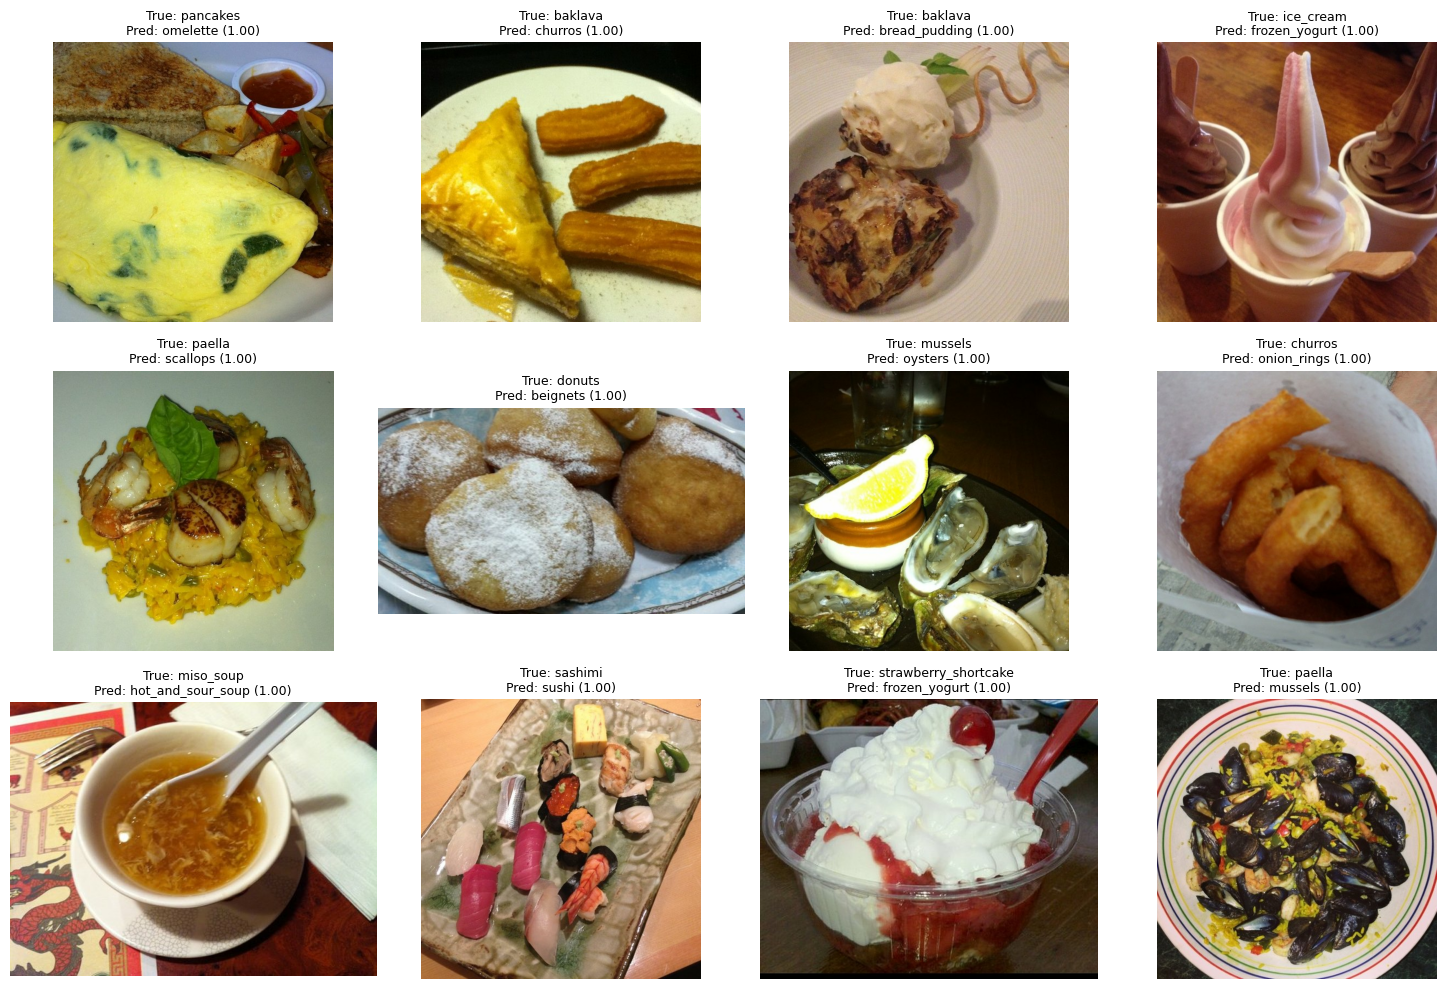

In [6]:
# Plot safely
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for j, (idx, image, true_label) in enumerate(selected):
    pred_label = y_pred[idx]
    conf = confidence[idx]

    plt.subplot(3, 4, j + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"True: {class_names[true_label]}\n"
        f"Pred: {class_names[pred_label]} ({conf:.2f})",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## A wrong prediction made with high confidence is more important than a wrong prediction made with low confidence.